In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import re

In [2]:
data = pd.read_csv('../data/data.csv')

In [55]:
data['trip_date'] = data['TRIP_ID'].astype('str') + data['CALENDAR_ID'].astype('str')

In [57]:
data["trip_date"].value_counts()

353036120230926    21
352966120230923    14
352272120230927    14
352287120230810    14
352900120230906    14
                   ..
353246120230918     2
353246120230911     2
353123120230911     2
352727120230911     2
353355120230815     1
Name: trip_date, Length: 67370, dtype: int64

In [4]:
trips = ''.join(data['TRIP_EDGE'].astype(str).tolist())

In [42]:
trips

'100210210021021002100210210210210210210210002102102100021021021021000210210021021000210210210210210210210210021021002102100210021021000210210002102100021021000210210210210002102102100021021021021000210210210210002102102021021000210210210002102102102100021021002102100021021021021000210210002102100021021000210210002102102102102102102102102102102102102102102102102102102102102102102102102102102102102100021021021021021021021021021021021021021021021021021021021021021021021021021021021021021021021002100210021002100210021002100210021002100210021002100210021002100210021002100210021002100210021002100210021002100210021002100210021002100210021002100210021002100210021002100210021002100210021002100210021002100210021002100210021002100210021002100210210021000002100210000021002100000210021000002100210000021002100000210021000002100210000021002100000210021002100210021002100210021000002102100210000021002100000210021000002100210000021002100000210021000002100210000021002100000210021000002100210021002100210

In [50]:
incomplete_trip_starts = [m.start() for m in re.finditer('20', trips)]

In [51]:
incomplete_trip_starts

[218,
 2485,
 4524,
 5166,
 6190,
 7960,
 7965,
 10517,
 14319,
 16001,
 17156,
 17690,
 21345,
 22665,
 23687,
 24545,
 28035,
 29268,
 29998,
 35607,
 36332,
 37939,
 39829,
 40025,
 40732,
 42292,
 43971,
 50621,
 50780,
 51071,
 52219,
 52223,
 53134,
 55632,
 56472,
 56951,
 56985,
 57140,
 58103,
 58109,
 58115,
 58627,
 61289,
 61762,
 63459,
 63641,
 67084,
 69996,
 70787,
 72310,
 73218,
 75519,
 78699,
 78801,
 79202,
 79209,
 79214,
 80311,
 83976,
 85413,
 86513,
 86800,
 88159,
 88668,
 88698,
 88703,
 90029,
 91026,
 91821,
 92004,
 92396,
 93037,
 96838,
 97519,
 98314,
 99318,
 99529,
 99534,
 101177,
 101553,
 101558,
 103507,
 106385,
 110200,
 110534,
 113421,
 113511,
 113725,
 113840,
 114547,
 114550,
 117067,
 119312,
 119776,
 119783,
 120340,
 124995,
 125001,
 125617,
 126834,
 128295,
 128299,
 130730,
 131419,
 132048,
 132446,
 133103,
 133434,
 133439,
 134936,
 135594,
 136833,
 137938,
 139614,
 142173,
 142413,
 142485,
 144044,
 144051,
 144335,
 14604

In [24]:
data.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'BLOCK_STOP_ORDER',
       'DWELL_IN_MINS'],
      dtype='object')

In [5]:
#Marks all trips whihc are complete (start with 1 and end with 2) as Complete_trip = True 
def mark_complete_trips():
    mydf = data.copy()
    mydf["Complete_trip"] = False
    trip_started = False
    for index, row in mydf.iterrows():
        trip_edge = row["TRIP_EDGE"]
        if trip_edge == 1:
            trip_started = True
            mydf.loc[index, "Complete_trip"] = True
        if trip_edge == 0 and trip_started:
          mydf.loc[index, "Complete_trip"] = True
        if trip_edge == 2 and trip_started:
          trip_started = False
          mydf.loc[index, "Complete_trip"] = True

    return mydf
        


In [58]:
data = mark_complete_trips()

In [59]:
data_complete_trips = data[data["Complete_trip"]==True]

In [60]:
data_complete_trips["TRIP_EDGE"].value_counts()

0    213873
1     67415
2     67415
Name: TRIP_EDGE, dtype: int64

In [68]:
start_adherences = data_complete_trips[data_complete_trips["TRIP_EDGE"] ==1]["ADHERENCE"]
end_adherences = data_complete_trips[data_complete_trips["TRIP_EDGE"] ==2]["ADHERENCE"]

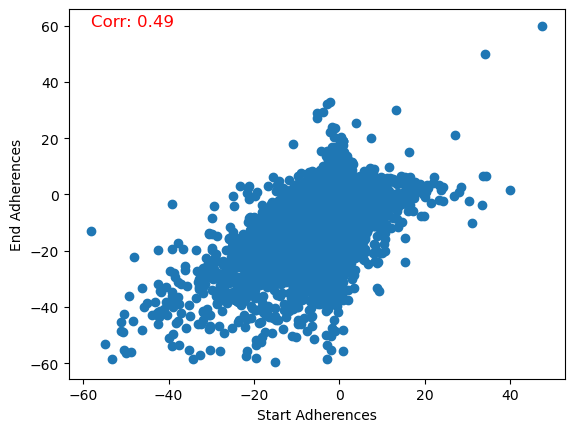

In [116]:
x_values = []
y_values = []
# lim = float('inf')
lim = 60
for x_value, y_value in zip(start_adherences, end_adherences):
    if not math.isnan(x_value) and not math.isnan(y_value) and abs(x_value) < lim and abs(y_value) < lim:
        x_values.append(x_value)
        y_values.append(y_value)
plt.scatter(x_values, y_values)
plt.xlabel("Start Adherences")
plt.ylabel("End Adherences")
correlation = np.corrcoef(x_values, y_values)[0, 1]
text_content = f"Corr: {correlation:.2f}"
textbox_x = min(x_values)  # X-coordinate for the top-left corner
textbox_y = max(y_values)  # Y-coordinate for the top-left corner (use the maximum y-value)
plt.text(textbox_x, textbox_y, text_content, fontsize=12, color='red')
plt.show()

In [97]:
data["PERC_HEADWAY_DEV"] = 100*data["HDWY_DEV"]/data["SCHEDULED_HDWY"]

In [110]:
u=data[["ADHERENCE", "SCHEDULED_HDWY", "HDWY_DEV"]].dropna()
u=u[u["SCHEDULED_HDWY"]>0]
u["PERC_HEADWAY_DEV"] = 100*u["HDWY_DEV"]/u["SCHEDULED_HDWY"]
u.describe()

,ADHERENCE,SCHEDULED_HDWY,HDWY_DEV,PERC_HEADWAY_DEV
count,265846.000000,265846.000000,265846.000000,265846.000000
mean,-3.503546,18.107747,0.517796,3.162384
std,6.501583,11.906063,7.162212,46.666825
min,-948.533333,2.000000,-64.000000,-100.000000
25%,-4.616666,10.000000,-2.316667,-14.166667
50%,-2.216666,15.000000,0.033333,0.175437
75%,-0.666666,20.000000,2.483333,15.500000
max,85.666666,503.000000,565.433333,2417.500000


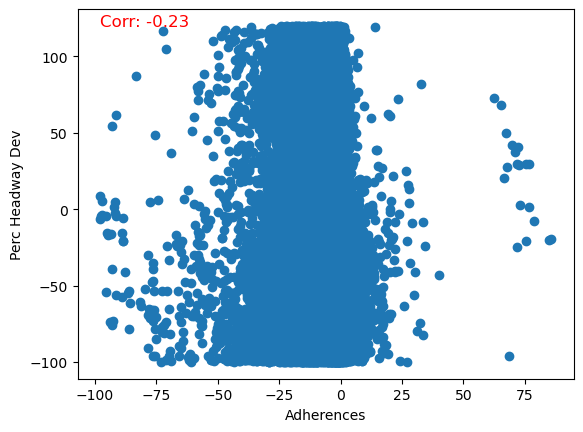

In [120]:
x_values = []
y_values = []
xlim = float('inf')
ylim = float('inf')
xlim = 100
ylim = 120
# lim = 60
for x_value, y_value in zip(u["ADHERENCE"], u["PERC_HEADWAY_DEV"]):
    if not math.isnan(x_value) and not math.isnan(y_value) and abs(x_value) < xlim and abs(y_value) < ylim:
        x_values.append(x_value)
        y_values.append(y_value)
plt.scatter(x_values, y_values)
plt.xlabel("Adherences")
plt.ylabel("Perc Headway Dev")
correlation = np.corrcoef(x_values, y_values)[0, 1]
text_content = f"Corr: {correlation:.2f}"
textbox_x = min(x_values)  # X-coordinate for the top-left corner
textbox_y = max(y_values)  # Y-coordinate for the top-left corner (use the maximum y-value)
plt.text(textbox_x, textbox_y, text_content, fontsize=12, color='red')
plt.show();

In [118]:
data["OPERATOR"].nunique()

341